In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_absolute_percentage_error


In [2]:
df = pd.read_excel("forecasting_monthly_data.xlsx")
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values(['Store', 'Month'])


In [3]:
results = []

In [4]:
# Loop through each store
for store_id in df['Store'].unique():
    store_data = df[df['Store'] == store_id].sort_values('Month')

    # Must have at least 12 months of data
    if len(store_data) < 12:
        print(f"Skipping Store {store_id} — not enough data.")
        continue

    store_data.set_index('Month', inplace=True)
    sales = store_data['Monthly_Sales']

    # Use all data except last month for training
    train_series = sales.iloc[:-1]
    test_value = sales.iloc[-1]
    test_date = sales.index[-1]

    try:
        # Seasonal model if enough data, else non-seasonal
        if len(train_series) >= 24:
            model = UnobservedComponents(train_series, level='local level', seasonal=12)
        else:
            model = UnobservedComponents(train_series, level='local level')

        result = model.fit(disp=False)

        # Forecast 1 step ahead (test)
        forecast = result.forecast(steps=1)[0]
        test_mape = mean_absolute_percentage_error([test_value], [forecast]) * 100

        # In-sample fitted values for train MAPE
        fitted_values = result.fittedvalues
        train_mape = mean_absolute_percentage_error(train_series, fitted_values) * 100

        results.append({
            'Store': store_id,
            'Forecast_Month': test_date,
            'Actual_Sales': test_value,
            'Forecasted_Sales': forecast,
            'Train_MAPE': round(train_mape, 2),
            'Test_MAPE': round(test_mape, 2),
            'Model_Used': 'UCM'
        })

    except Exception as e:
        print(f"⚠️ UCM failed for Store {store_id}: {e}")

c:\Users\LopamudraMohapatra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\LopamudraMohapatra\AppData\Local\Temp\ipykernel_18148\262399349.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = result.forecast(steps=1)[0]
c:\Users\LopamudraMohapatra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\LopamudraMohapatra\AppData\Local\Temp\ipykernel_18148\262399349.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

In [5]:
# Export results
forecast_df = pd.DataFrame(results)
forecast_df.to_excel("ucm_forecast_with_mape.xlsx", index=False)

print("✅ UCM forecasting with Train and Test MAPE complete.")

✅ UCM forecasting with Train and Test MAPE complete.


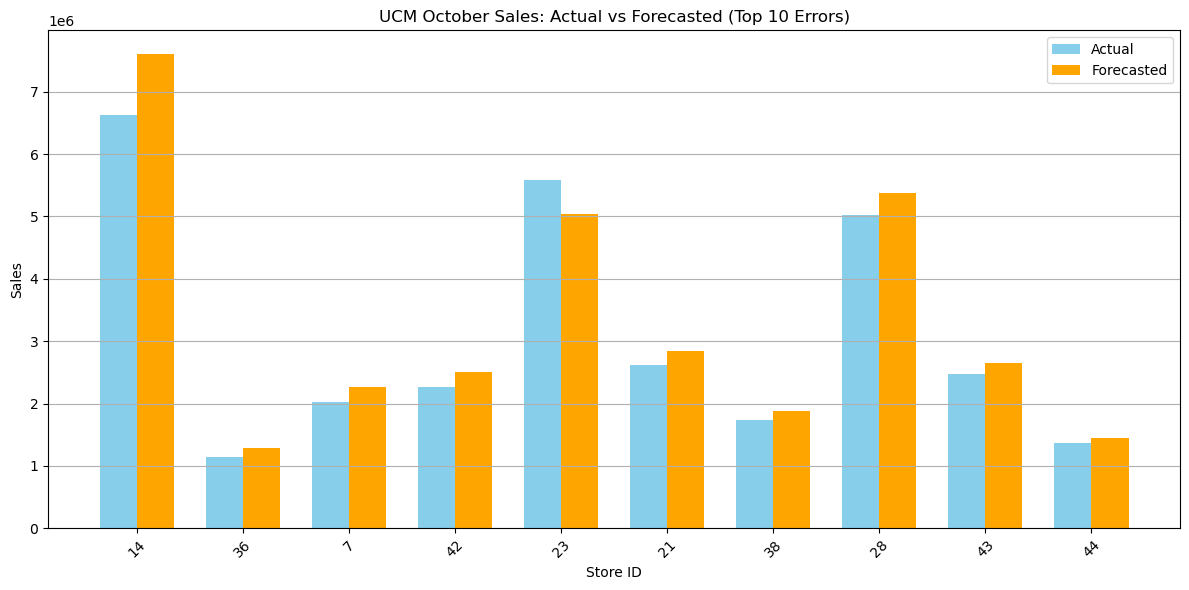

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by Test MAPE and take top N
top_n = 10
plot_df = forecast_df.sort_values("Test_MAPE", ascending=False).head(top_n)

x = np.arange(len(plot_df))
width = 0.35

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, plot_df['Actual_Sales'], width, label='Actual', color='skyblue')
plt.bar(x + width/2, plot_df['Forecasted_Sales'], width, label='Forecasted', color='orange')

# Formatting
plt.xticks(x, plot_df['Store'], rotation=45)
plt.ylabel('Sales')
plt.xlabel('Store ID')
plt.title(f'UCM October Sales: Actual vs Forecasted (Top {top_n} Errors)')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()

# Show plot
plt.show()
